Import Libraries

In [63]:
import logging
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix
)

Configurate logging settings

In [64]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

Load the data from the file path and return a pandas dataframe

In [65]:
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        logging.error("The file was not found.")
        raise
    except pd.errors.EmptyDataError:
        logging.error("The file is empty.")
        raise
    except pd.errors.ParserError:
        logging.error("Error parsing the file.")
        raise

Preprocess the data and splitting it into training and testing sets

In [66]:
def preprocess_data(df):
    df.drop(columns=['entry'], inplace=True)
    df.dropna(inplace=True)
    X = df.drop(columns=['target'])
    y = df['target']
    return X, y

Build a model pipeline with a classifier and its hyperparameters. This pipeline consists of a StandardScaler and the classifier model to be used for training and prediction. Scaler is used to standardize the features by removing the mean and scaling to unit variance. Classifier is the model to be used for training and prediction.

In [67]:
def build_model_pipeline(model, params):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ]), params

 Evaluate the performance of the trained machine learning model. It takes as input a model and test data, and computes various performance metrics such as accuracy, precision, recall, and F1 score. These metrics provide a quantitative measure of the model's ability to correctly predict the target variable on unseen data.

In [68]:

def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'Train Score': model.score(X_train, y_train),
        'Test Score': model.score(X_test, y_test),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }
    return metrics

Plot the metrics for each that provide a visual representation of the model's performance. 

In [69]:
def plot_metrics(results):

    metrics = list(next(iter(results.values())).keys())
    metrics.remove('Confusion Matrix')

    for metric in metrics:
        model_names = []
        metric_values = []
        for model_name, model_metrics in results.items():
            model_names.append(model_name)
            metric_values.append(model_metrics[metric])

        plt.figure(figsize=(10, 7))
        sns.barplot(x=metric_values, y=model_names, palette='viridis', hue=model_names)
        plt.ylabel('Model')
        plt.xlabel(metric)
        plt.title(f'Model / {metric}')
        plt.show()

    for model_name, model_metrics in results.items():
        plt.figure(figsize=(10, 7))
        sns.heatmap(model_metrics['Confusion Matrix'], annot=True, fmt='d', cmap='viridis')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

Define the collection of machine learning models that are used in this project. Each model in this collection will be trained and evaluated on the provided dataset. The performance of these models can then be compared to select the most effective model for this specific task.

In [70]:
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100],
            'classifier__max_depth': [20],
            'classifier__min_samples_split': [2],
            'classifier__min_samples_leaf': [2],
            'classifier__max_features': ['sqrt']
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'classifier__C': [1],
            'classifier__kernel': ['rbf'],
            'classifier__gamma': ['scale']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'classifier__C': [1],
            'classifier__solver': ['lbfgs']
        }
    }
}

 Entry point of this program. It contains the primary logic of the script and orchestrates the execution of the program's functionality. This can include tasks such as loading data, preprocessing, training models, evaluating performance, and displaying results. 

In [71]:
def main():

    df = load_data(rf'data\aac.csv')

    X, y = preprocess_data(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    best_hyperparameter = {}
    results = {}

    for model_name, model_spec in models.items():
        pipeline, params = build_model_pipeline(model_spec['model'], model_spec['params'])

        grid_search = GridSearchCV(pipeline, param_grid=params, cv=skf, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_hyperparameter[model_name] = grid_search.best_estimator_

        cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=skf, scoring='accuracy')

        results[model_name] = evaluate_model(grid_search.best_estimator_, X_train, X_test, y_train, y_test)
        results[model_name]['Cross Validation Score'] = cv_scores.mean()

        logging.info(f"Best parameters for {model_name}: {grid_search.best_params_}")

    plot_metrics(results)

2024-06-01 11:28:40,058 - INFO - Best parameters for RandomForest: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
2024-06-01 11:28:43,456 - INFO - Best parameters for SVC: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
2024-06-01 11:28:43,860 - INFO - Best parameters for LogisticRegression: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}


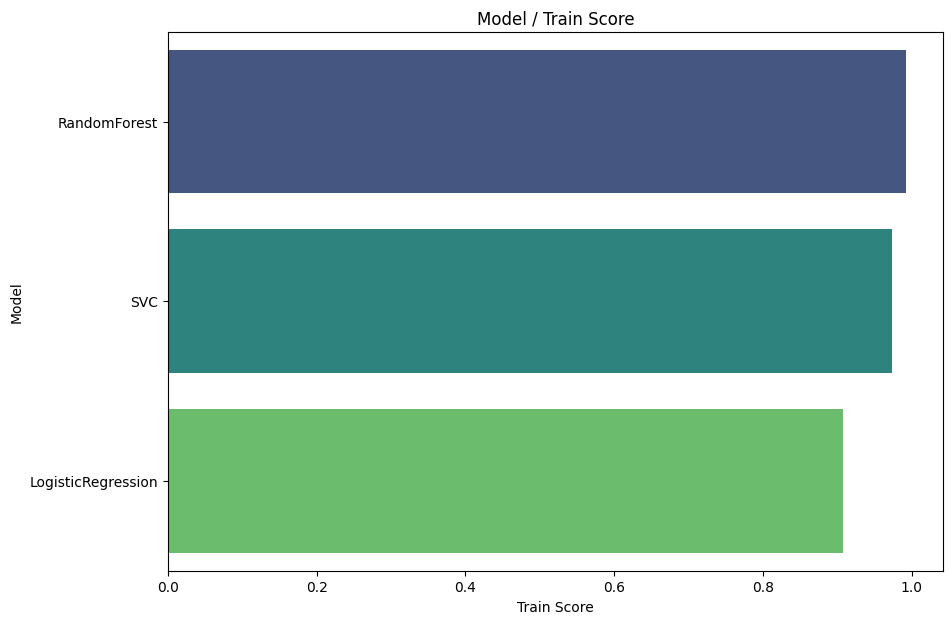

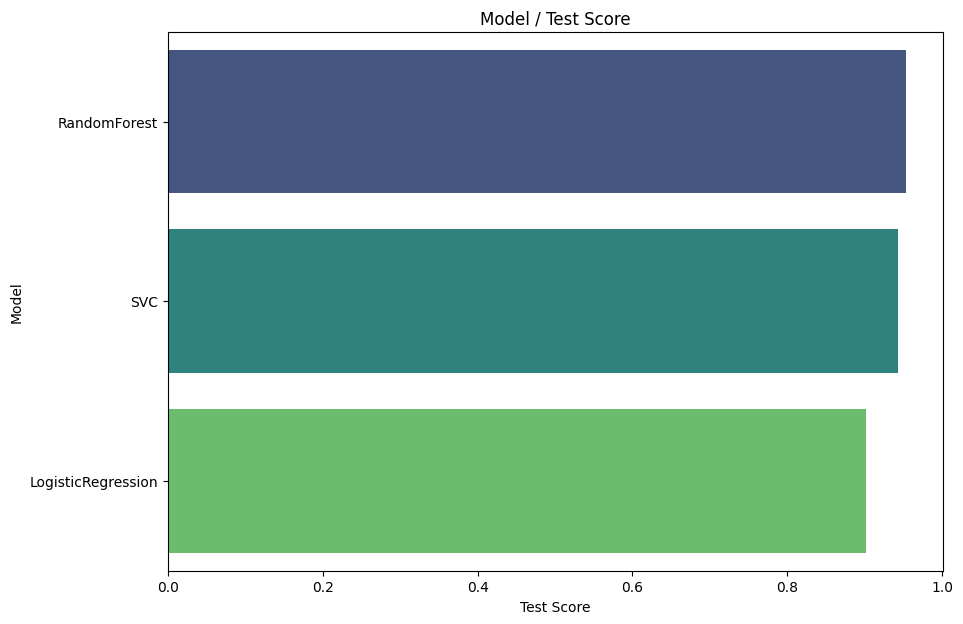

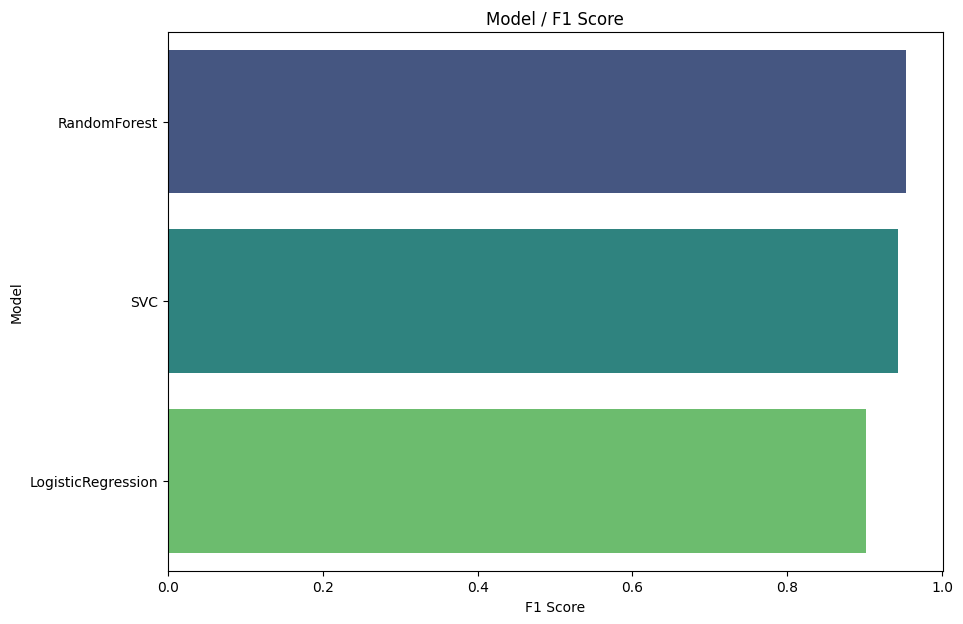

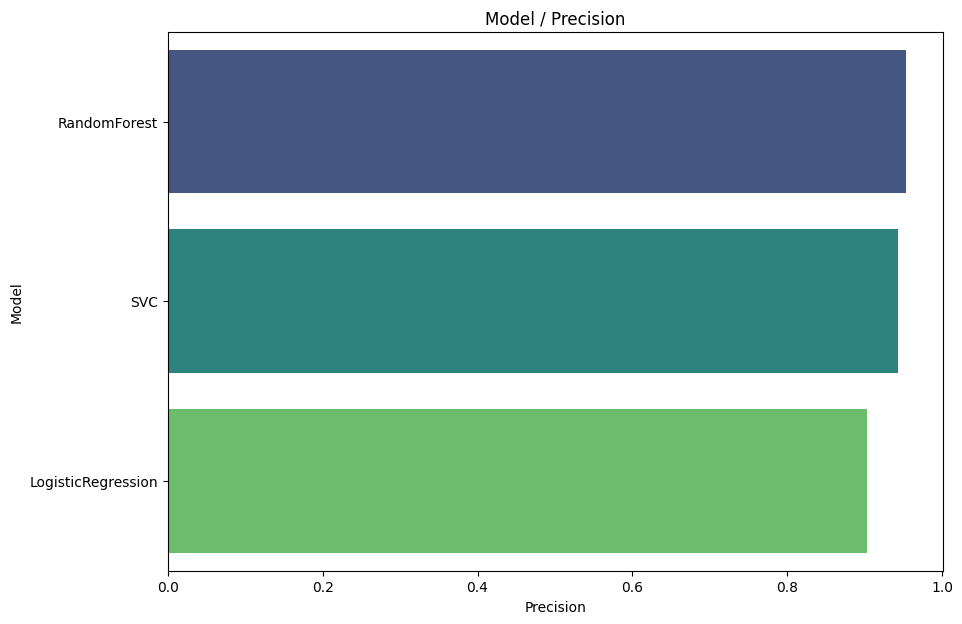

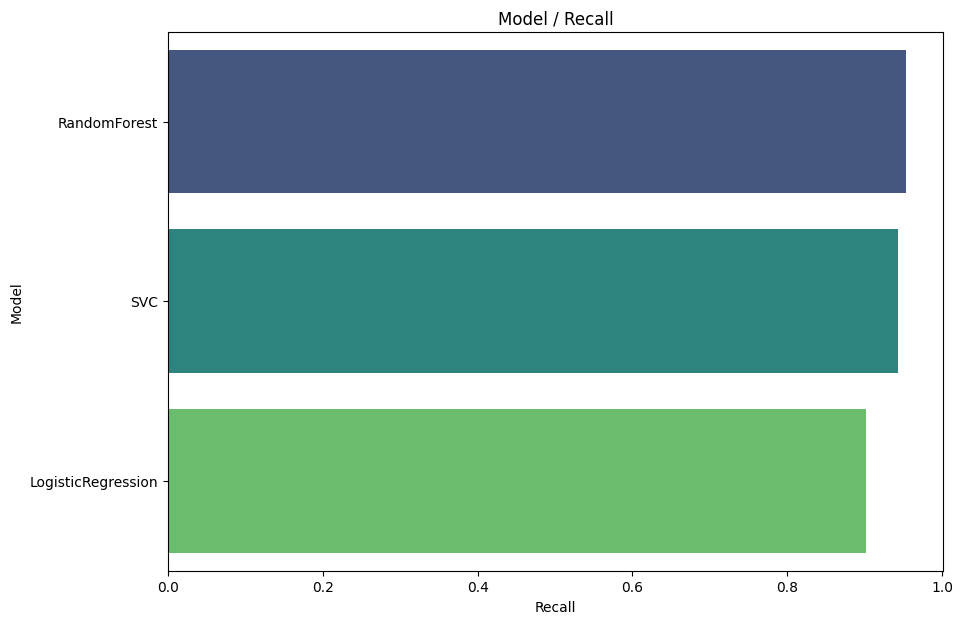

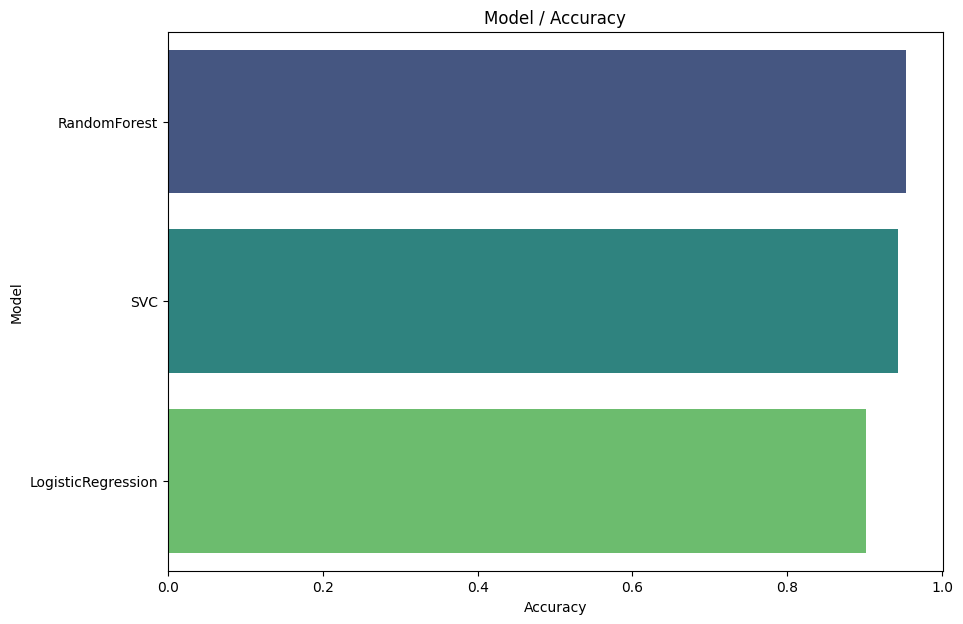

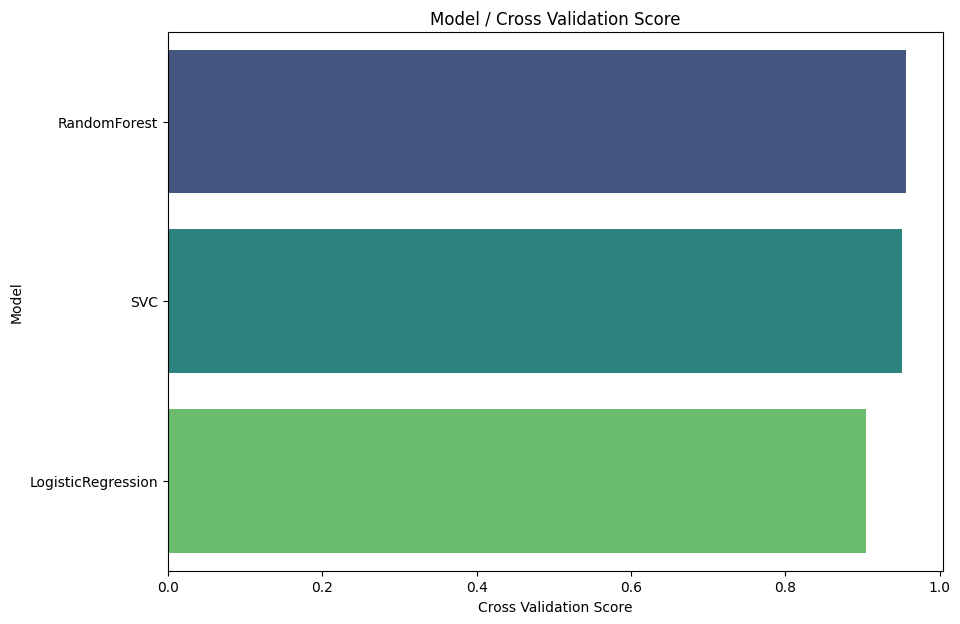

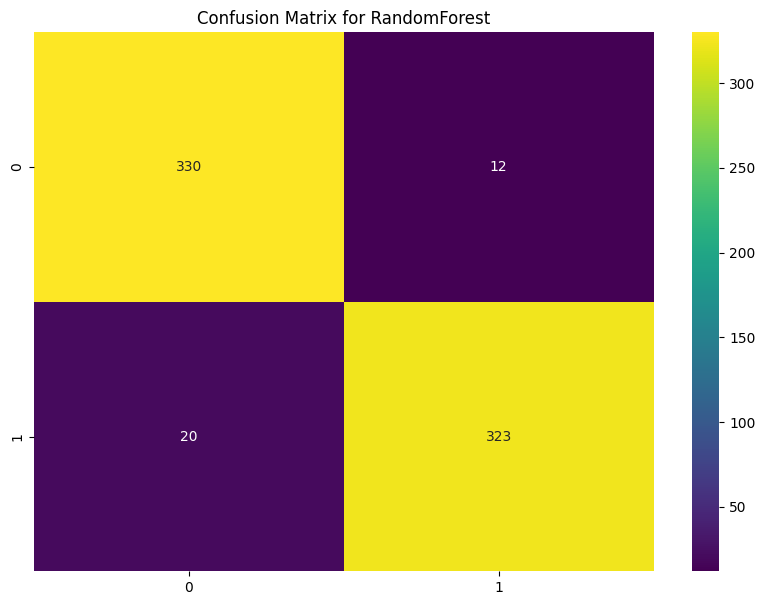

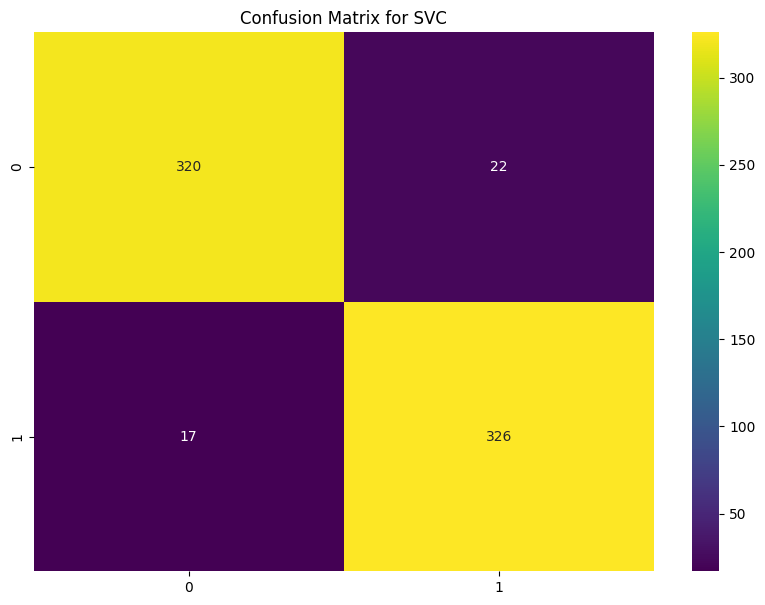

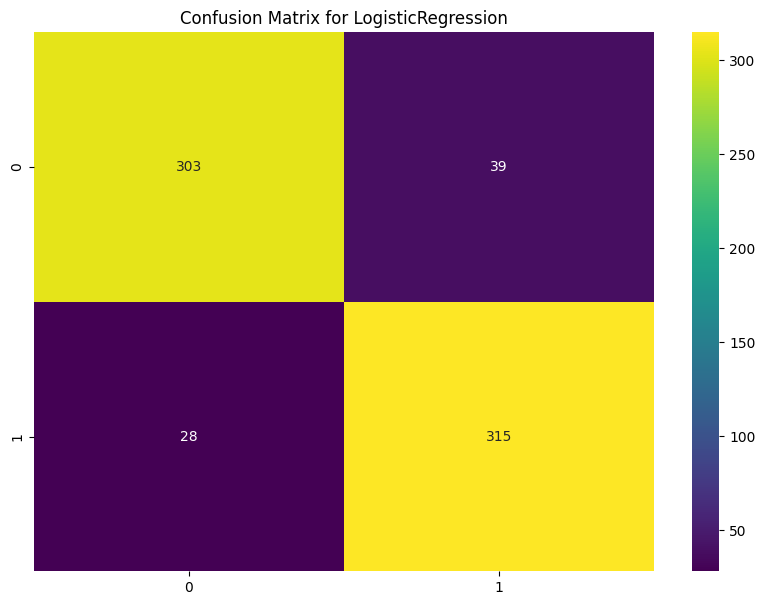

In [72]:
if __name__ == "__main__":
    main()